In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/aco_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:
import numpy as np

def calculate_conflicts(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    num = 0

    for edge in graph.edges():
        indicator = True

        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                indicator = False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                indicator = False

        if indicator:
            num += 1
    
    return len(graph.edges()) - num

def ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_edges  # Initially set the number of colors to the number of nodes
    best_iter = 0
    
    # Initialize pheromone matrix with small random values
    pheromone_matrix = np.random.rand(num_edges, num_colors)
    
    # Initialize best coloring and its value
    best_coloring = np.zeros(num_edges, dtype=int)
    best_value = float('inf')
    
    for iteration in range(num_iterations):
        # Initialize ant solutions
        ant_solutions = np.zeros((num_ants, num_edges), dtype=int)
        
        # Construct ant solutions
        for ant in range(num_ants):
            for edge in range(num_edges):
                probabilities = np.zeros(num_colors)
                if graph.has_node(edge):  # Check if edge is a valid node
                    for color in range(num_colors):
                        probabilities[color] = (pheromone_matrix[edge][color] ** alpha) * ((1 / (graph.degree(edge) + 1)) ** beta)
                    
                sum_probabilities = np.sum(probabilities)
                if sum_probabilities == 0:
                    probabilities = np.ones_like(probabilities) / len(probabilities)
                else:
                    probabilities /= sum_probabilities
                ant_solutions[ant][edge] = np.random.choice(range(num_colors), p=probabilities)
        
        # Update pheromone matrix locally
        for ant in range(num_ants):
            value = calculate_conflicts(graph, ant_solutions[ant])
            if value < best_value:
                best_value = value
                best_coloring = ant_solutions[ant]
                best_iter = iteration
                for edge in range(num_edges):
                    pheromone_matrix[edge][ant_solutions[ant][edge]] += pheromone_deposit
        
        # Global update of pheromone matrix
        pheromone_matrix *= (1 - evaporation_rate)
        for edge in range(num_edges):
            for color in range(num_colors):
                if color == best_coloring[edge]:
                    pheromone_matrix[edge][color] += pheromone_deposit / (best_value + 1e-10)

    # Update number of colors if a better coloring is found
        if value < best_value  and is_valid_coloring(graph, ant_solutions[ant]):
            best_coloring = ant_solutions[ant]
            best_value = value
            best_iter = iteration
    
    return best_coloring, best_value, len(np.unique(best_coloring)), best_iter

In [9]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    num_ants = 10
    num_iterations = 500
    
    alpha = 1
    beta = 1
    evaporation_rate = 0.2
    pheromone_deposit = 1
    
    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_coloring, best_value, num_colors, best_iter = ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit)
            end_time = time.time()
            print("Best Coloring:", best_coloring)
            print("Best Value:", best_value)
            print("Number of Colors:", num_colors)
            write_output(graph, file, best_coloring, best_iter, start_time, end_time)

Running test graph_101_edges.txt...
Best Coloring: [ 91  21  35  94  59  15  55  67 100  41  32  20  97  25  88  75  22  43
  65  78  72  39   6  74  33   5  54  75   7  25  45  93  82  57  76   6
  97  86  83  98  94  35   1  97  73  70  31  77  17  78  32  19  45  14
  86  54  57  87  45  31  14  45   3  90  78  68  74  19  37  10  34  17
  36  29  44  21  73  26  27  78  74  73  54   9  15   1   6  99  20   7
  64  76  17  81  61  85  74  96  26  62   2]
Best Value: 2
Number of Colors: 65
[ 91  21  35  94  59  15  55  67 100  41  32  20  97  25  88  75  22  43
  65  78  72  39   6  74  33   5  54  75   7  25  45  93  82  57  76   6
  97  86  83  98  94  35   1  97  73  70  31  77  17  78  32  19  45  14
  86  54  57  87  45  31  14  45   3  90  78  68  74  19  37  10  34  17
  36  29  44  21  73  26  27  78  74  73  54   9  15   1   6  99  20   7
  64  76  17  81  61  85  74  96  26  62   2]
Minimum edge coloring found.
Number of colors: 65
Number of iterations: 81


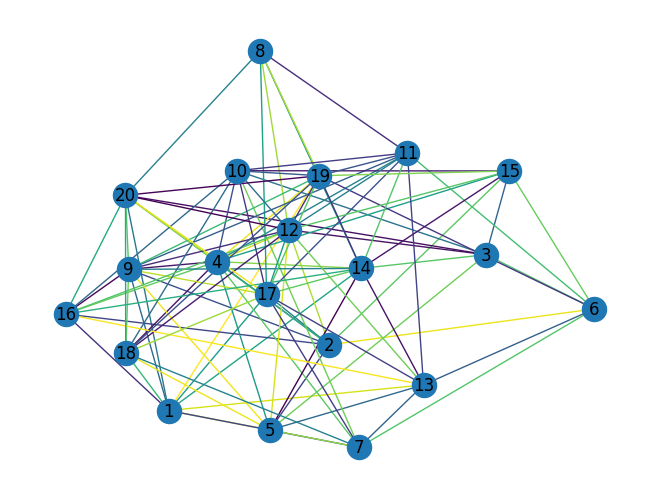

Time taken: 51.671809911727905 seconds

Running test graph_121_edges.txt...
Best Coloring: [107 114 111  39  50  32  56  21 106   3  15  45  27 112   6  78  50 103
   1  80  27 108 120  19  59  82  70  87  41  90   9  21  15  69  89 116
  16  47  45  11  82  30  76  54  95  55  71  39  43  95  16  60  23  38
  85  64  26 110  92  82  44  11  70 107  58   4  68  64  15  61  66  21
  38  66  62  42 103 102 116  99  75  30  73 106  28  12  81  15 119  44
  68  76  95  53  88   0 112  36   1 109  89  33   6  34  88  80  72 103
  31  27  19  89  72   3  34  27  87  28  69  22  39]
Best Value: 4
Number of Colors: 76
[107 114 111  39  50  32  56  21 106   3  15  45  27 112   6  78  50 103
   1  80  27 108 120  19  59  82  70  87  41  90   9  21  15  69  89 116
  16  47  45  11  82  30  76  54  95  55  71  39  43  95  16  60  23  38
  85  64  26 110  92  82  44  11  70 107  58   4  68  64  15  61  66  21
  38  66  62  42 103 102 116  99  75  30  73 106  28  12  81  15 119  44
  68  76  95  53 

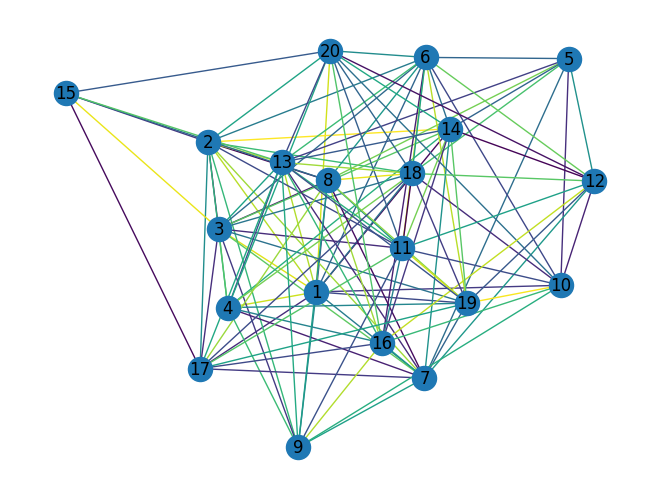

Time taken: 67.06085658073425 seconds

Running test graph_140_edges.txt...
Best Coloring: [ 97  36  15  92  29  72  35  23   8  61 125 126  44 108  36  85  10  12
  88  33   3 128  53 103  19 110  84  15 136   2 127  27  67  90 138 110
  46  43  34  50  64   6  74  16  24  54  61  27  56 122  32  26 105  50
 118  36  98 119  38  91  31  40  79  91  16 110 104  67 120  95  52 138
  21 120  11  34 105  15 119 109 127  64  17 115  98   9   8 127 132  92
   8  89 111 110  69  36 114  27  56 134   4  97 119  81  65   0  88 123
  58  16   4  74 128 139  87 138   2  65 102  71  80  26  45 132 111 114
 107  49 139  14  16  32 101 107 109  36  83 124 108  18]
Best Value: 4
Number of Colors: 91
[ 97  36  15  92  29  72  35  23   8  61 125 126  44 108  36  85  10  12
  88  33   3 128  53 103  19 110  84  15 136   2 127  27  67  90 138 110
  46  43  34  50  64   6  74  16  24  54  61  27  56 122  32  26 105  50
 118  36  98 119  38  91  31  40  79  91  16 110 104  67 120  95  52 138
  21 120  11  

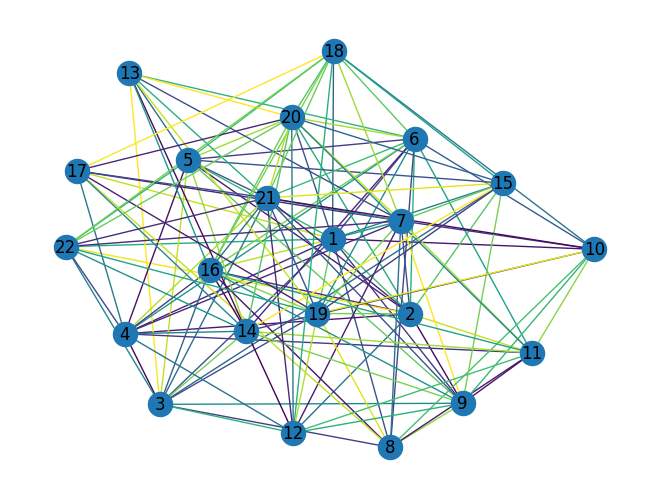

Time taken: 84.73299098014832 seconds

Running test graph_156_edges.txt...
Best Coloring: [ 94  66 148  33 131  40  28  44  45  67  41  14  21  32  12  58  70  59
  32 118 114  91 150   7  34  27  75 129  58  10 151  67  60 125 152  24
  51  59  37 154  20 130   0  26  43  16  67  13  94  34  43 141 124 115
 118  17 148 125 154 111  75 131 120  24  57 103  40  12  53  72 117 146
  83 115  49  93 114  78  14  65 131  27  45 125   2  20 137 100 124   4
 118 139  92   5 127  47  79 106  42 141  65  55  46   2 151  33 138 121
  72  70  15  35 152  46  44  82 140   5  17  63  16 140  69  88  50  37
   9  42 104  71 113  60 130  40 130   4 149  63  58  17  61 104  69 124
 133 129  89 118 151 143 150  16  51  28   2 126]
Best Value: 6
Number of Colors: 94
[ 94  66 148  33 131  40  28  44  45  67  41  14  21  32  12  58  70  59
  32 118 114  91 150   7  34  27  75 129  58  10 151  67  60 125 152  24
  51  59  37 154  20 130   0  26  43  16  67  13  94  34  43 141 124 115
 118  17 148 125 154 1

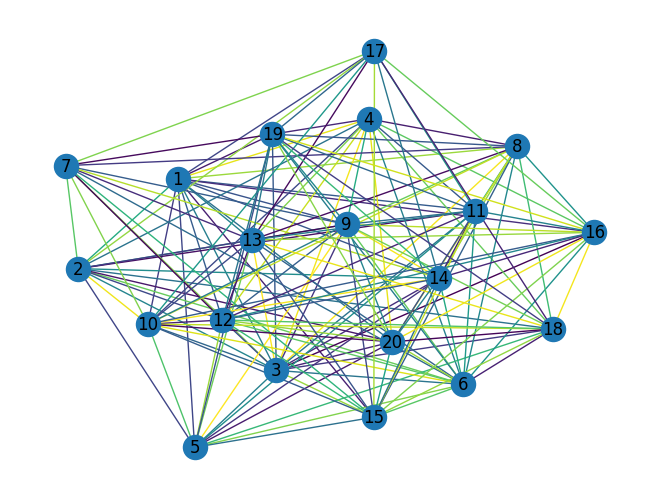

Time taken: 95.82107162475586 seconds

Running test graph_165_edges.txt...
Best Coloring: [ 12 126  73 122 130 114 148  29 116  84 133 148   4  83 128 116  75  71
  89  13 113  15  35  84  49  76  19  20  10  34  24  63 111 157  14  88
   0 110  38  29 135  37   8  10  24 133 104   0  58 107 125 109  11 114
  58  21 118  32  63   9  27   1 160 119  68 122 153 136  73 137  14 111
 119 130  14  13 162  49  55  18  26  31 122 155 164  21 135 119  58  46
 147 120 140 120 149  36 136 139   6 130  12  16 113  66  71 139 123 100
 160  93 163  98 143  18 125  25 158  23 138  32  13  47 147  60   5 111
  82  56  88  24  62  41  55  33  25  17   3  31  37 122  87  41 159 161
  64 127  48  34  38  97  79  21 124  83 133 162 137  78   7 123 111 117
 144  18 160]
Best Value: 4
Number of Colors: 107
[ 12 126  73 122 130 114 148  29 116  84 133 148   4  83 128 116  75  71
  89  13 113  15  35  84  49  76  19  20  10  34  24  63 111 157  14  88
   0 110  38  29 135  37   8  10  24 133 104   0  58 107 

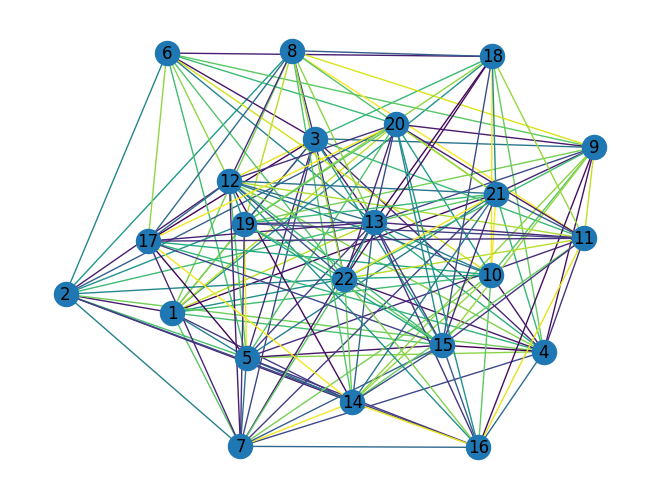

Time taken: 108.33348369598389 seconds

Running test graph_177_edges.txt...
Best Coloring: [127  11  74  39 170  53  69 152  47 169  13  90  92  96 129   9 101  20
  58 124  21 102 173  80   7  42  39   1  88 169  59  94 150  38 133  32
  73  38  31  43 103  99 135  91 154  69 165  88 126 126 165 154  75  37
 170 108  22 135 120 110  16  30 117 141  62 151 149 122  41  65  85 150
  13 151  10  14 133  99  64 129 140  16 133 131 141  66   6  71  55  54
 111  90 120 126 158   7  20  67  11  22 146  76 159 105 157  66  71 137
  34  15  64 108  57  35   2  91  68  70  34 105  29 108  75  14 155   1
 157 140 149   9 134  91 119  87  61  95  43  17  21  92 148 170  36 138
 132  82  59 123 115 163  56 129  88  82 134  58   6 101 107 112  49 100
 144 131 101 176  24 161  39 114 130  21   4 102  79 129  99]
Best Value: 7
Number of Colors: 116
[127  11  74  39 170  53  69 152  47 169  13  90  92  96 129   9 101  20
  58 124  21 102 173  80   7  42  39   1  88 169  59  94 150  38 133  32
  73  38

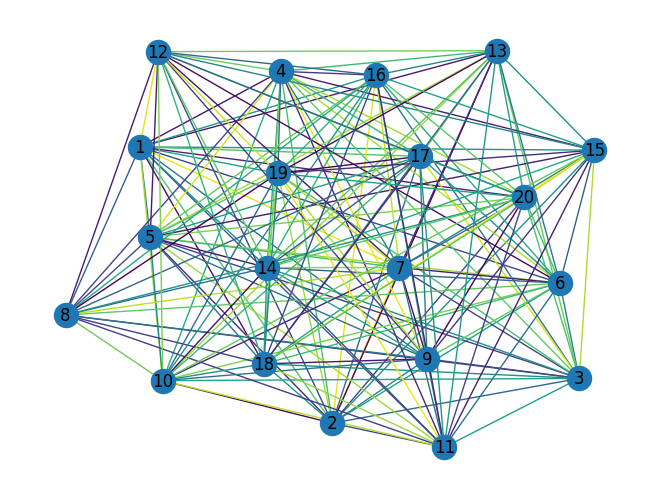

Time taken: 115.97700834274292 seconds

Running test graph_204_edges.txt...
Best Coloring: [ 37 133 153  69  58  37  82  93 146  84  77 179  98  72  51 196 100 120
 121  13 106 177  93  90  43 174  62  91 151  84  67 133  48 148 202 159
  44 131   2  40 150 118 100  84 127 197  27 186 198  82 110 119 142 134
  88  62  96 157 187  42  19 141  13   0  83  75  32 100  64  53  73  11
  40  98 188   8 192 193  33 155  50 102  24 193 158  99 171 159  14 104
  29 177 130  42 187  38  55 131  56 158 132 124 198  73  46  90  14   4
 130 152 123  33  75  83  38 173 137 138  17  54 148  95  14  49  76 103
  17 183   4 108 160  10  82 110 141 155 138 127 110 144 110  77 200 136
 182  92  54 179  30  68 127  11 126 139 170 175 200  30 134 151 141  52
  43  99  21  97  41 120 140  68 160 150 197 106 202 190 181  82 162  34
 151  96 122   2  40 157  61 173 125  69 129  44  80 176 184 119 108 117
  53 188  23 107 183 170]
Best Value: 8
Number of Colors: 130
[ 37 133 153  69  58  37  82  93 146  84  77

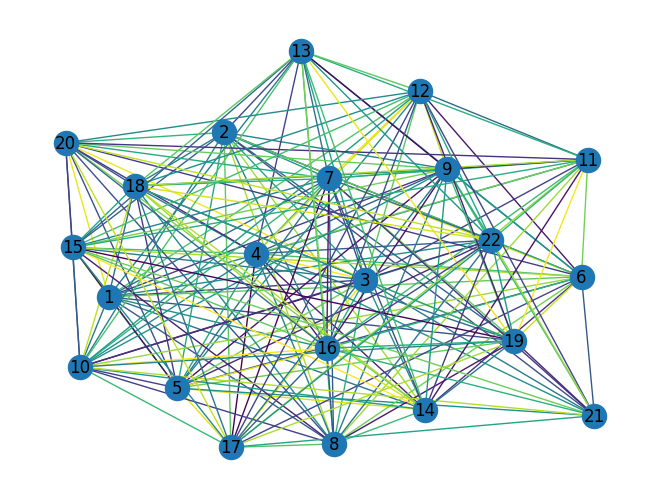

Time taken: 159.66960263252258 seconds

Running test graph_227_edges.txt...
Best Coloring: [216  41 196  64 110  25  99 105  59 144 176 205 173  33 211 159 184 110
  90 145  22   9 216 111 149 111 105  99  77 123  64  97 197 187 204   0
  11  84 200  10 182 186  54 192  64 183  17  15  12 215 177 207 221  76
  57  13 224 151  30 178 109  61  58 144 122 141 191  88 101  98 140  20
 202 172 166 171  74 101 125  28  80 147 193  41  67  76 196 191 124  81
  31  11 116 132 166 115 171  32  15 148 168  20   1 203  28   7 105 202
 111  77  87  80  58  97 114 159 104 126  74 145  60 134  79  98 158  94
 166 207  79 120  49 123 155 139 103 125 160 217  27 150 170  54  67 203
  80 141 184  53  31  62  34  48 223 194 165  65  50 156 198  93 128  62
 102  28 197  86  65 109 123 195  35 103 152 177  36  78 137 120  26  42
 182  43 118 122 143 184 216 204  51  70  99 210 164 133  91  95 217 135
 210  21  56 154  82  52  20 192  31 113 140  23 105  89  44  38  85 206
  67  52   7 208  76  20 223  69 

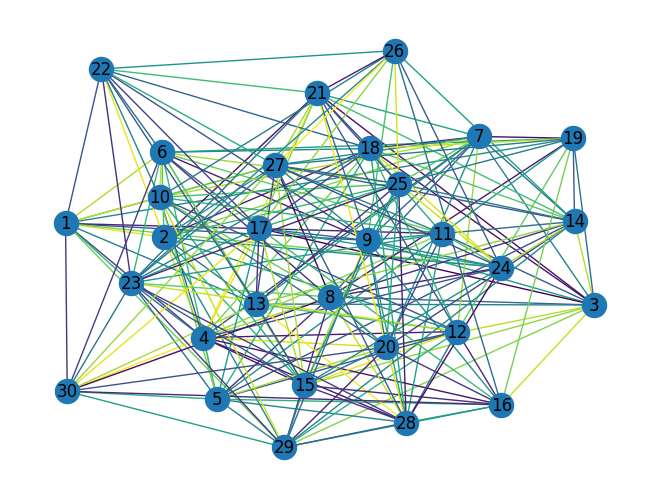

Time taken: 190.77109694480896 seconds

Running test graph_273_edges.txt...
Best Coloring: [183   1 242 268 251 211 232 191 186  92 105 224  41  27 253 224 236 148
 155  19 158  82 126  75 229 170  71 161 239 262  57  87 206 179 235 269
 270 218 258  25  17  66 102 211  79 222 240  55  24  14  12 105  48 221
 264 113 272 170 231 179  16 249 228 235 154  51 119 199 156 247  90  71
 224 186 244 164   7  26 203 123 121 134  88  58 192 239  96  67 120 185
  26 139  47 187 208  73 150 117   9 193  62 147 189 201 187 165  26  15
  86 130 260 228   8  11 160 113  46 181  29  71 198 208 216   9 213  26
 221  48 222 200 153 129 130  96 128   8 150 262 244  41  44 217 123 164
 221  47  43 210 112  69 100  35 112 164 200 206 268 254  18 178   8  28
 126  20 248 125 150 249 255 198 252 129 206  65 225   9 146 194 175  40
  17  60  71 257 139 149 200 118  90   6 174 152 229 192 153 182  70 194
 210 223 130 117   2 164   5  91 254  89 166 200  17 108 158 257  14  40
  55  79 112  43 149 195  67 131 

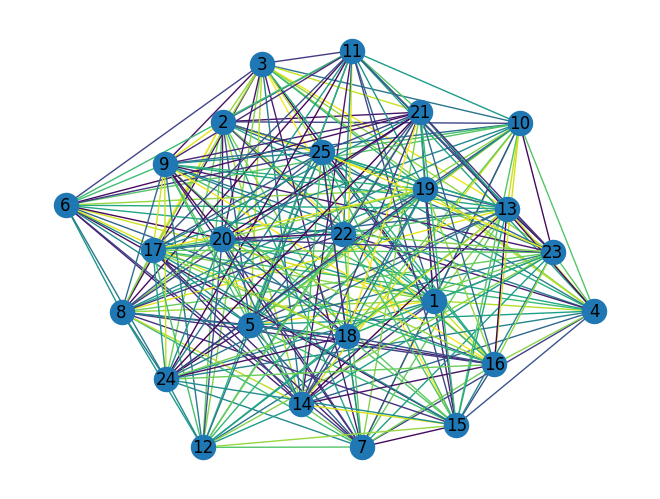

Time taken: 242.48903679847717 seconds

Running test graph_275_edges.txt...
Best Coloring: [ 99 272  60  12 114  16   1  47 107  78  15 208  18  86 205 151  85 227
 244 123  18 154  67 181 209  38 141 131  16  40  36 174 205 106 266 259
  89  80 247 170 221 232 207  35 260 142 155 145 153  76 166  75  42 258
 185 116  24   0  59 115  34 154 200  17  38 260 103 111 181 199   9 185
 197 255 214 146 166  57 258 221  54  30  78  87  60 138  47  51  74  55
  95  35 172   8 143 174  90 125 121  74 250  78 199 253 271 169  58 261
  61 132  84   4 144  44  88  35  11 177 274  66 125 102 264 184  76 149
 268 204 134  67 130 193  24  61 193  60  50  47  79  15 131 233   6 179
  53  64  37 156 183 243   5  38 104  26 121 136  17 123 185 115 141  84
 243 259 136 209 232 147  90 238  57 215  53 113 218 226  18 168 185  22
  41 147 126  67 252 102   7  75 235  64  65  31  88 272 109 149 163   8
 111  47  56 218  11 110   4  93 206 260 265  81 115   2  86 224 187 120
 211 146 101  77  55 190  16 162 

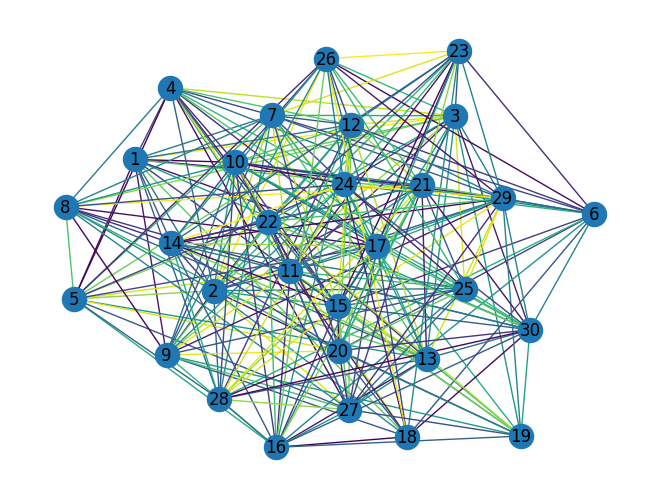

Time taken: 253.7578103542328 seconds



In [10]:
with open('./results/aco_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')